
# Understanding and Predicting Spanish Wine Ratings

Wine is not just a drink, it's a culture, especially in Spain, where winemaking is an integral part of life. 
This project analyzes a dataset of Spanish wines, aiming to understand what makes a great wine. We explore various factors like wine regions, prices, and types to uncover patterns, and then predict the ratings of these wines based on those features.

The key questions we aim to answer are:
- What factors correlate with higher wine ratings?
- Can we predict the quality of wine based on its attributes?

The insights gained from this project could be useful for wine producers, connoisseurs, and even businesses in the hospitality industry. 

### Importance of This Research
Understanding how wine ratings relate to its characteristics can have significant implications:
- **Producers** can focus on the attributes that lead to higher-rated wines, increasing profitability.
- **Consumers** benefit by making informed purchase decisions based on attributes like price and type.
- **Retailers** can stock wines that are likely to receive high ratings, improving customer satisfaction.


### Dataset

| Name        | Description                                                                                                                                       |
|-------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| winery      | Winery name                                                                                                                                       |
| wine        | Name of the wine                                                                                                                                  |
| year        | Year in which the grapes were harvested                                                                                                           |
| rating      | Average rating given to the wine by the users [from 1-5]                                                                                          |
| num_reviews | Number of users that reviewed the wine                                                                                                            |
| country     | Country of origin [Spain]                                                                                                                         |
| region      | Region of the wine                                                                                                                                |
| price       | Price in euros [€]                                                                                                                                |
| type        | Wine variety                                                                                                                                      |
| body        | Body score, defined as the richness and weight of the wine in your mouth [from 1-5]                                                               |
| acidity     | Acidity score, defined as wine's “pucker” or tartness; it's what makes a wine refreshing and your tongue salivate and want another sip [from 1-5] |

### Questions Explored

1. What is the top winery in Spain by the number of wines produced, per region?

2. What are the top 5 wines? What are their ratings, prices, and types?

3. From which year come the best/worst wines? And the most expensive/cheap ones?

4. What is the average prices of a wine by type? And by winery?

5. Creating a price/quality metric that using the different features, rates the wines. What are the top 5 wines by this metric?

6. Studying the correlation between the features and the price of the wine.

7. Using a linear regression model to predict the price of the wine.

8. Making a prediction of the price of a wine with the following features: winery = 'Alvaro Palacios', wine = 'L'Ermita Velles Vinyes Priorat', year = 2023, rating = 4.5, num_reviews = 321, region = 'Priorato', type = 'Priorat Red', body = 4.5, acidity = 3.0.

9. Using a random forest regressor model to predict the price of the wine with the previous features.

10. Now, we want to predict the possible rating of a wine, given the features (including the price). What kind of model would you use? Why?

11. Creating a pipeline to predict the rating of a wine.

12. Fine-tuning and comparing a Suppor Vector Model, a Gradient Boosting or Random Forest Model, and a Naïve Bayes Model.

13. What are the most important features that determine the rating?

14. Designing and training a simple neural network to predict the rating of a wine.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

%matplotlib inline
sns.set_style('ticks')
sns.set_palette("Spectral")

In [36]:
df = pd.read_csv("/Users/emiliosayun/Documents/Msc Management Business Analytics/3rd Term/Data Science/Final Project/data/spanish_wines_dataset.csv", sep=',', encoding='utf-8', header=0)
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


# Exploratoy Data Analysis

In [37]:
# Check the variable types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       2048 non-null   object 
 1   wine         2048 non-null   object 
 2   year         2046 non-null   object 
 3   rating       2048 non-null   float64
 4   num_reviews  2048 non-null   int64  
 5   country      2048 non-null   object 
 6   region       2048 non-null   object 
 7   price        2048 non-null   float64
 8   type         1942 non-null   object 
 9   body         1777 non-null   float64
 10  acidity      1777 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 176.1+ KB


In [38]:
# Check null values and duplicates

print(f'Number of null values: {df.isnull().sum().sum()}')
print(f'Number of duplicates: {df.duplicated().sum()}')

Number of null values: 650
Number of duplicates: 0


In [39]:
# Drop nulls

df.dropna(inplace=True)

In [40]:
# Drop the country column since it only has 1 unique entry: Espana

df = df.drop(columns=['country'])

In [41]:
# 'year' cannot be directly transformed to numeric because it has a string 'N.V.'
# Check unique entries in the 'year' column
year_unique = df['year'].unique()
print(f'Unique entries in the year column:\n {year_unique}')

# Count and print number of 'N.V.' entries
count_nv = (df['year'] == 'N.V.').sum()
print(f'\nTotal number of N.V. entries: {count_nv}')

# Remove rows where 'year' is 'N.V.'
df = df[df['year'] != 'N.V.']



Unique entries in the year column:
 ['2013' '2018' '2009' '1999' '1996' '1998' '2010' '1995' '2015' '2011'
 '2016' '1970' '1946' '1962' '2019' '2004' 'N.V.' '1931' '1979' '2005'
 '2020' '2014' '1985' '1929' '2007' '2012' '2017' '2008' '2006' '2000'
 '2003' '2002' '1991' '1994' '1990' '1989' '1987' '1986' '1981' '2001'
 '1968' '1964' '1982' '1974' '1983' '1955' '1980' '1972' '1953' '1958'
 '1942' '1965' '1992' '1973' '1997' '1967' '1975' '1910' '1961' '1954'
 '1988' '1969' '1951' '1928' '1976' '1949' '2021' '1959' '1922' '1978'
 '1925']

Total number of N.V. entries: 61


In [42]:
# Convert 'year' to numeric

df['year'] = pd.to_numeric(df['year'])

In [43]:
# Separate the numeric variables

num_cols = pd.DataFrame (df, columns= ['year', 'rating', 'num_reviews', 'price', 'body', 'acidity'])

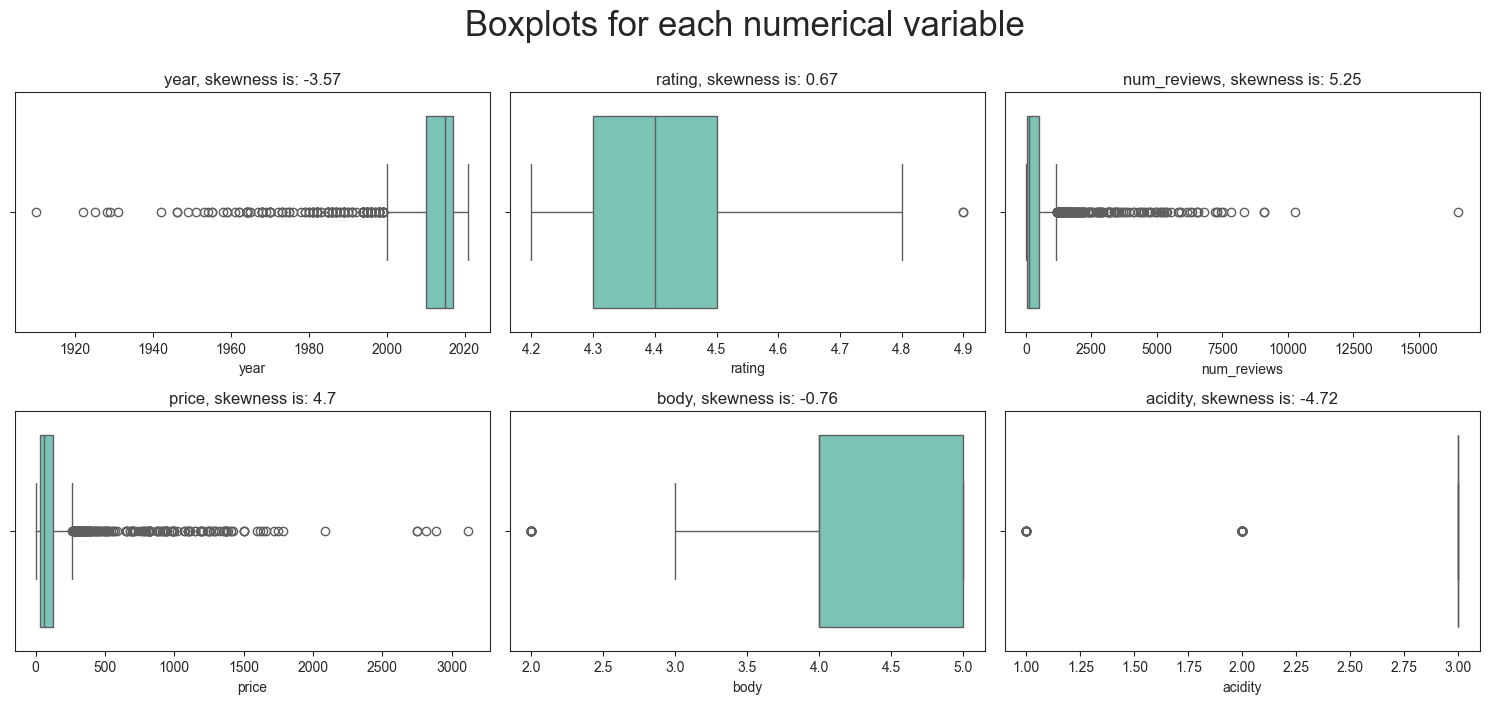

In [44]:
# Check distribution of the numeric variables with boxplots

def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(15,7))
    fig.suptitle(suptitle, y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', color='#6fcfbc', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True), 2)))
        
boxplots_custom(dataset=df, columns_list=num_cols, rows=2, cols=3, suptitle='Boxplots for each numerical variable')
plt.tight_layout()

In [45]:
# Calculate the IQR for each numerical variable
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using the IQR method
outliers = ((num_cols < (Q1 - 1.5 * IQR)) | (num_cols > (Q3 + 1.5 * IQR)))

# Count the number of outliers for each variable
num_outliers = outliers.sum()

# Number of outliers for each variable
num_outliers.to_frame().T

,year,rating,num_reviews,price,body,acidity
0,158,2,184,201,34,96


Although the numeric variables are highly skewed and appear to show outliers outside the IQR, we will not delete them as they provide important descriptive information on the observations. They also comprise over 30% of all observations in the cleaned dataset.

The most concerning variables are 'year', 'num_reviews', and 'price'. We would only consider to scale 'num_reviews' and 'price', since 'year' is a nominal variable.

However, we decided NOT to scale our numeric variables for the following reasons:
- MinMaxScaler: the distributions of the variables are too skewed and show many outliers. MixMax scaler would lead to information loss.
- StandardScaler: by making the mean 0, it would create negative values, which could lead to incorrect predictions on price. Also, it does not guarantee balanced feature scales in the presence of outliers.

Therefore, we will conduct a logarithmic transformation of the variables instead, once they are needed.

# What is the top winery in Spain by the number of wines produced, per region?

In [46]:
# Group by winery and count the number of unique wine entries
wine_counts = df.groupby('winery').size().reset_index(name='wine_count')

# Sort the wineries by wine count in descending order and get the top winery
most_wines_winery = wine_counts.sort_values(by='wine_count', ascending=False).iloc[0]

print(f"The winery that produces the most wines in Spain is: {most_wines_winery['winery']} with {most_wines_winery['wine_count']} wines.")

The winery that produces the most wines in Spain is: Vega Sicilia with 95 wines.


In [47]:
# Group by region and winery to count the number of wines produced
winery_counts_by_region = df.groupby(['region', 'winery']).size().reset_index(name='wine_count')

# Get the top winery in each region by the number of wines produced
top_winery_per_region = winery_counts_by_region.loc[winery_counts_by_region.groupby('region')['wine_count'].idxmax()]

# Sort the results by wine count in descending order
top_winery_per_region_sorted = top_winery_per_region.sort_values(by='wine_count', ascending=False).reset_index(drop=True)

top_winery_per_region_sorted


,region,winery,wine_count
0,Ribera del Duero,Vega Sicilia,95
1,Priorato,Alvaro Palacios,44
2,Vino de Espana,Artadi,37
3,Rioja,Marques de Murrieta,33
4,Montilla-Moriles,Toro Albala,23
...,...,...,...
58,Otazu,Bodega Otazu,1
59,Cigales,La Legua,1
60,Monterrei,Ladairo,1
61,Ribeiro,Luis A. Rodriguez Vazquez,1


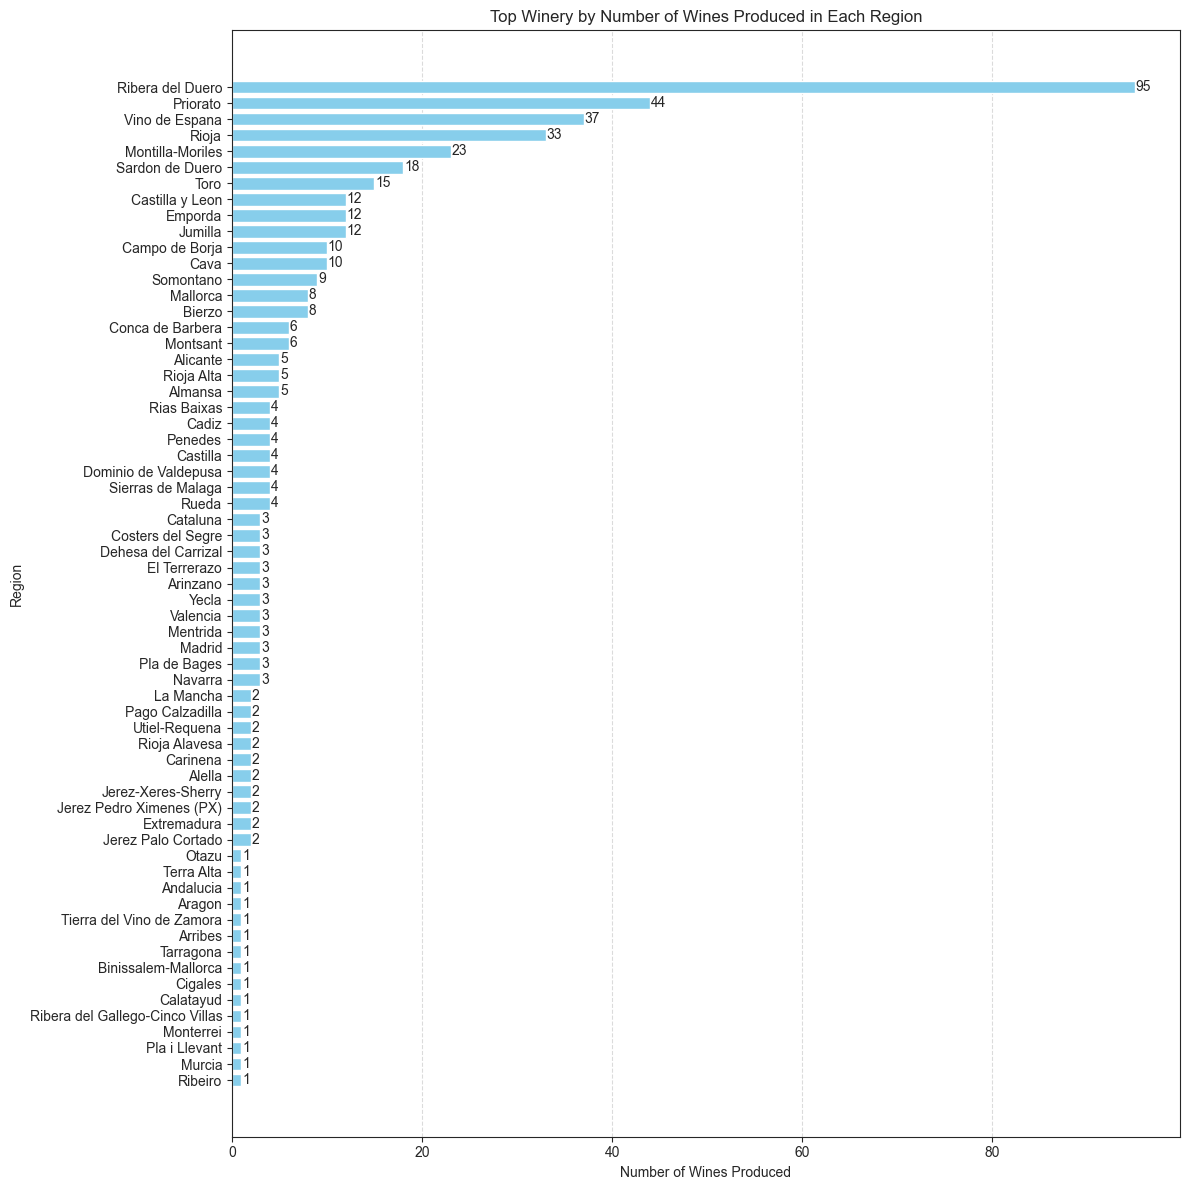

In [48]:
# Sort the dataframe by wine count in descending order
top_winery_per_region_sorted = top_winery_per_region.sort_values(by='wine_count', ascending=True)

plt.figure(figsize=(12, 12))
bars = plt.barh(top_winery_per_region_sorted['region'], top_winery_per_region_sorted['wine_count'], color='skyblue')
plt.xlabel('Number of Wines Produced')
plt.ylabel('Region')
plt.title('Top Winery by Number of Wines Produced in Each Region')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add the wine count next to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center')

plt.tight_layout()
plt.show()

Vega Sicilia leads in Ribera del Duero with 95 wines, followed by Alvaro Palacios in Priorato with 44 wines. This visual representation shows how wine production is concentrated in a few notable wineries throughout various regions, showing the dominance of key players such as Vega Sicilia and Alvaro Palacios in the Spanish wine sector. On the other extreme, there are 15 wineries in the same number of areas that produce only one wine.

The top 5 wineries are located in the north of Spain, with the exception of Toro Albala in Montilla Moriles, which is located in Andalusia.

# What are the top 5 wines? What are their ratings, prices, and types?

In [49]:
# Group by wine to calculate the average rating, price, and count the number of reviews
wine_stats = df.groupby('wine').agg({
    'rating': 'mean',
    'price': 'mean',
    'type': 'first',
}).reset_index()

# Sort by average rating in descending order and select the top 5 wines
top_5_wines = wine_stats.sort_values(by='rating', ascending=False).head(5)

top_5_wines[['wine', 'rating', 'price', 'type']]

,wine,rating,price,type
510,Ribera Del Duero Gran Reserva 12 Anos,4.800000,999.000000,Ribera Del Duero Red
361,Magico,4.800000,544.500000,Rioja Red
634,Vatan Arena Tinta de Toro,4.800000,369.050000,Toro Red
191,El Anejon,4.750000,90.125000,Ribera Del Duero Red
623,Unico Reserva Especial Edicion,4.730435,742.232174,Ribera Del Duero Red


The top 5 wines in Spain, by average rating, are:
- Ribera Del Duero Gran Reserva 12 Anos
- Magico
- Vatan Arena Tinta de Toro
- El Anejon
- Unico Reserva Especial Edicion

The average ratings range between 4.73 and 4.8, demonstrating their high level of acclaim. The prices of these wines vary significantly, from €90.13 to €999.00. This suggests that while some top-rated wines are relatively affordable, others are considered ultra-luxury items. Moreover, all are red wines indicating that these are preferred by sommaliers over white wines.

# From which year come the best/worst wines? And the most expensive/cheap ones?

In [50]:
# Calculate the average rating and price per year
yearly_stats = df.groupby('year').agg({
    'rating': 'mean',
    'price': 'mean'
}).reset_index()

# Identify the year with the highest average rating
best_year = yearly_stats.loc[yearly_stats['rating'].idxmax()]

# Identify the year with the lowest average rating
worst_year = yearly_stats.loc[yearly_stats['rating'].idxmin()]

# Identify the most expensive year by average price
most_expensive_year = yearly_stats.loc[yearly_stats['price'].idxmax()]

# Identify the cheapest year by average price
cheapest_year = yearly_stats.loc[yearly_stats['price'].idxmin()]

print(f"Year with the highest average rating:\n{best_year}\n")
print(f"Year with the lowest average rating:\n{worst_year}\n")
print(f"Most expensive year by average price:\n{most_expensive_year}\n")
print(f"Cheapest year by average price:\n{cheapest_year}\n")


Year with the highest average rating:
year      1929.00
rating       4.80
price      227.95
Name: 4, dtype: float64

Year with the lowest average rating:
year      1925.0
rating       4.3
price      532.0
Name: 2, dtype: float64

Most expensive year by average price:
year      1965.000
rating       4.600
price     1514.515
Name: 18, dtype: float64

Cheapest year by average price:
year      2021.000
rating       4.300
price       11.972
Name: 69, dtype: float64



In 1929, wines received the highest average rating of 4.80, accompanied by a premium average price of €227.95, signifying great quality at a higher cost. Conversely, 1925 had the lowest average grade of 4.3, with wines priced much higher at €532, implying inferior quality and greater pricing. Moving on to costs, 1965 stands out as the most costly year, with wines averaging €1514.52, and a decent grade of 4.60. In contrast, 2021 is the cheapest year, with wines selling at an average of €11.97, resulting in a good grade of 4.30. 

Unsurprisingly, the most expensive and highly regarded wines were created in the last century, whereas lower-cost wines were produced more recently. This can be explained by the fact that the longer a wine is aged, the higher its value.

# What is the average prices of a wine by type? And by winery?

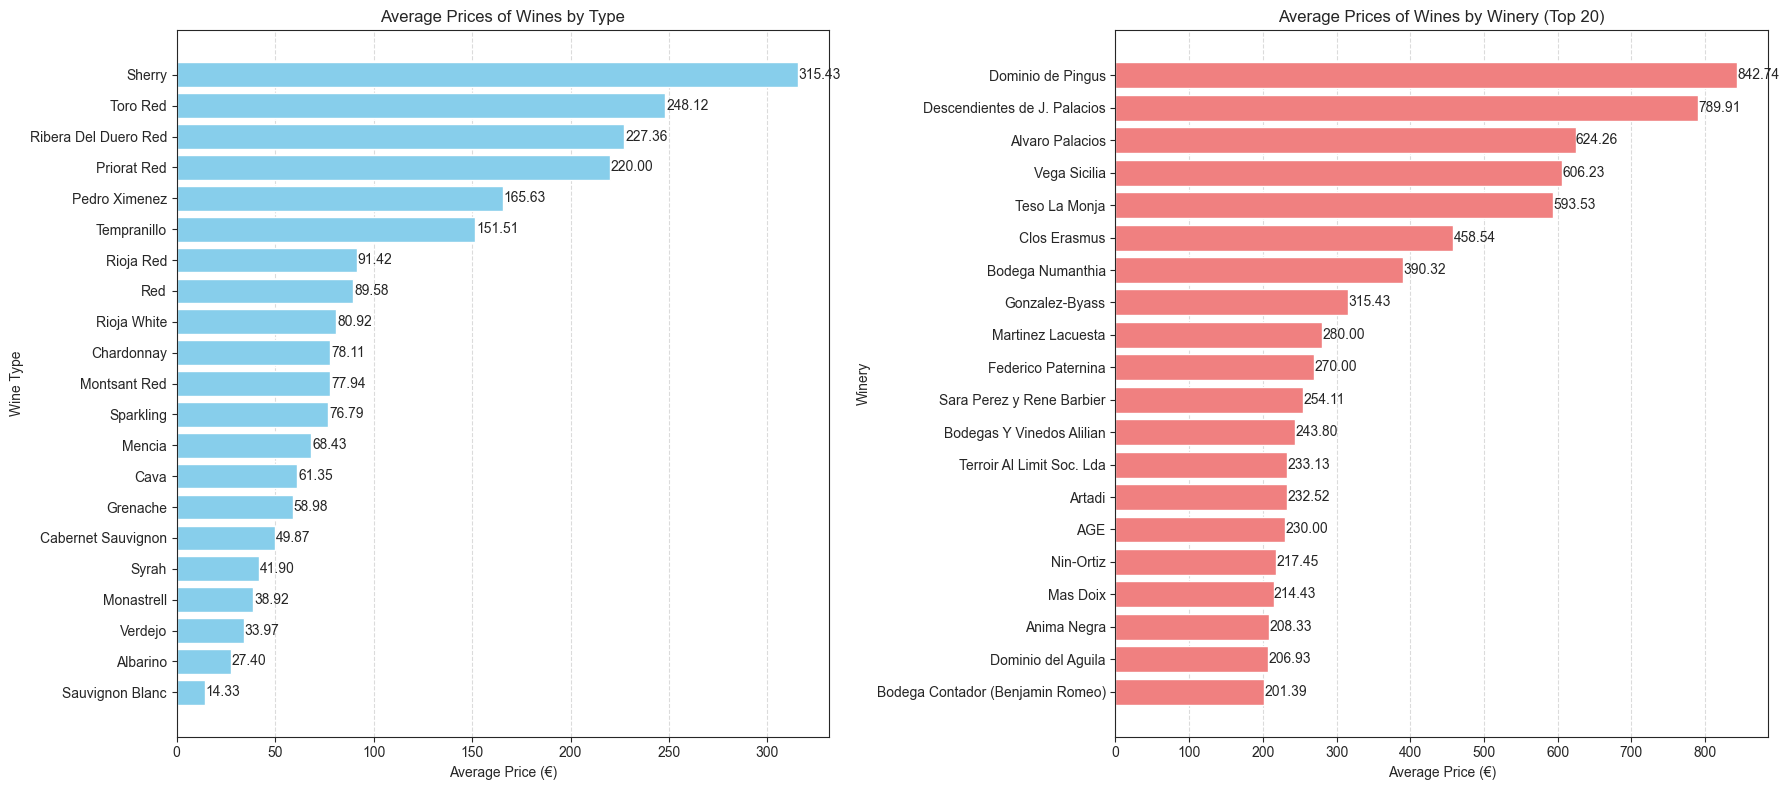

In [51]:
# Calculate the average price of a wine by type
average_price_by_type = df.groupby('type')['price'].mean().reset_index()

# Calculate the average price of a wine by winery
average_price_by_winery = df.groupby('winery')['price'].mean().reset_index()

# Sort dataframes
average_price_by_type_sorted = average_price_by_type.sort_values(by='price')
top_20_wineries = average_price_by_winery.nlargest(20, 'price')
top_20_wineries_sorted = top_20_wineries.sort_values(by='price')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot for average prices of wines by type
bars1 = ax1.barh(average_price_by_type_sorted['type'], average_price_by_type_sorted['price'], color='skyblue')
ax1.set_xlabel('Average Price (€)')
ax1.set_ylabel('Wine Type')
ax1.set_title('Average Prices of Wines by Type')
ax1.grid(axis='x', linestyle='--', alpha=0.7)

# Add the price next to the bars
for bar in bars1:
    width = bar.get_width()
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

# Plot for average prices of wines by winery (showing only the top 20)
bars2 = ax2.barh(top_20_wineries_sorted['winery'], top_20_wineries_sorted['price'], color='lightcoral')
ax2.set_xlabel('Average Price (€)')
ax2.set_ylabel('Winery')
ax2.set_title('Average Prices of Wines by Winery (Top 20)')
ax2.grid(axis='x', linestyle='--', alpha=0.7)

# Add the price next to the bars
for bar in bars2:
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.tight_layout()
plt.show()

The left graph displays the average prices of various wine types. Sauvignon Blanc and Albarino are the most affordable, with average prices of €14.33 and €27.40, respectively. On the higher end, Sherry, Toro Red, and Ribera Del Duero Red wines command the highest prices, with Sherry topping the list at an average of €315.43.

The right graph shows the average prices of wines from the top 20 wineries. Dominio de Pingus leads with an average price of €842.74, followed closely by Descendientes de J. Palacios at €789.91 and Alvaro Palacios at €624.26. On the other hand, wineries like Bodega Contador (Benjamin Romeo) and Dominio del Aguila, while still among the top 20, have relatively lower average prices of €201.39 and €206.93, indicating a more accessible price point.

# Creating a price/quality metric that using the different features, rates the wines. What are the top 5 wines by this metric?

In [52]:
# Create a new df for this question
df5 = df.copy()

# Standardize price and rating to remove the effect of the different units of measurement
df5['price_standardized'] = (df['price'] - df['price'].mean()) / df['price'].std()
df5['rating_standardized'] = (df['rating'] - df['rating'].mean()) / df['rating'].std()

# Calculate price_quality using standardized values
df5['price_quality'] = df5['rating_standardized'] / df5['price_standardized']

# Get the top 5 wines based on price-quality ratio
top_5_wines = df5.sort_values(by='price_quality', ascending=False).head(5)

print('The top 5 wines in terms of price to quality ratio are:')
print(top_5_wines[['wine', 'year', 'price', 'rating', 'price_quality']])


The top 5 wines in terms of price to quality ratio are:
                         wine  year   price  rating  price_quality
103    Parcela El Picon Tinto  2009  154.00     4.7     194.669766
1608       Clos Fonta Priorat  2001  150.00     4.3     192.768548
1518  Prado Enea Gran Reserva  1982  150.00     4.3     192.768548
85                    El Nido  2017  154.85     4.7     150.106019
70                    El Nido  2014  154.90     4.7     148.111568


The Parcela El Picon Tinto (2009) stands out with a price of $154.00 and a rating of 4.7, achieving the highest price-quality ratio of 194.67. This indicates it provides the most quality per unit price among the listed wines.

Following closely are the Clos Fonta Priorat (2001) and Prado Enea Gran Reserva (1982), both priced at $150.00 with a rating of 4.3, each achieving a ratio of 192.77. These wines, while slightly less expensive, offer significant value due to their high quality ratings.

The El Nido (2017) and El Nido (2014), priced at $154.85 and $154.90 respectively, both with a rating of 4.7, achieve ratios of 150.11 and 148.11. Despite their higher price, they still offer excellent quality for their cost.

These wines collectively illustrate the best options for consumers seeking high-quality wines that provide the most value for their price.

# Studying the correlation between the features and the price of the wine.

In [53]:
# Encode categorical variables
categorical_columns = ['winery', 'wine', 'region', 'type']

encoder = LabelEncoder()
label_mapping = {}

for column in categorical_columns:
    df[column] = encoder.fit_transform(df[column])
    # Store the mapping of labels to encoded values
    label_mapping[column] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

We use LabelEncoder, instead of OneHotEncoder, to make the results of the correlation matrix more interpretable.

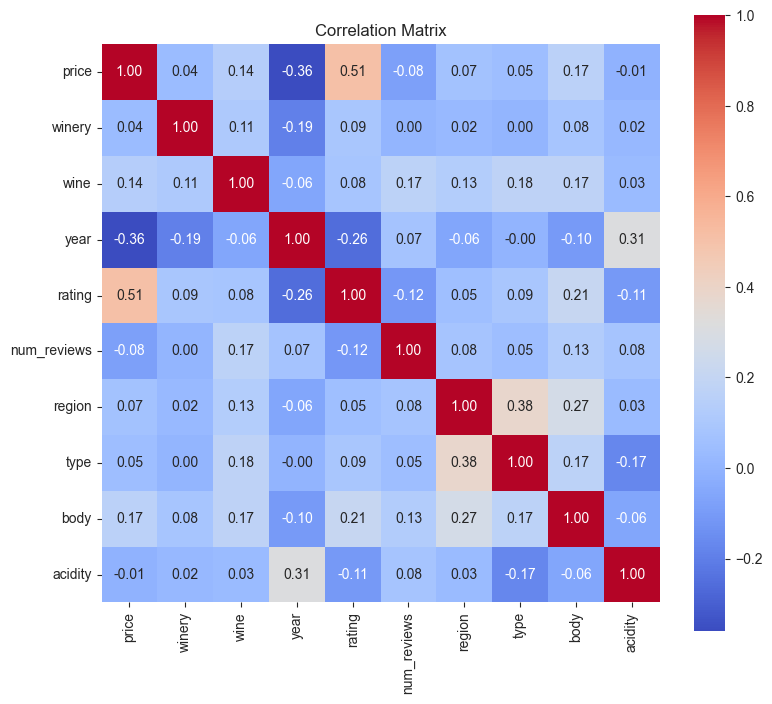

In [54]:

# Define columns to include in correlation matrix
columns_order = ['price'] + [col for col in df.columns if col != 'price']

# Correlation matrix
corr_matrix = df.corr()

# Reorder the correlation matrix
reordered_corr_matrix = corr_matrix.loc[columns_order, columns_order]

# Plotting heatmap with formatted annotations
plt.figure(figsize=(9, 8))
sns.heatmap(reordered_corr_matrix, annot=True, fmt='.2f', cmap="coolwarm", square=True)
plt.title('Correlation Matrix')
plt.show()

In [55]:
# Calculate correlation coefficients and p-values
correlations = {}
p_values = {}

for feature in df.columns:
    if feature != 'price':
        corr, p_value = pearsonr(df[feature], df['price'])
        correlations[feature] = corr
        p_values[feature] = p_value

results_df = pd.DataFrame({
    'Correlation with Price': correlations,
    'p-value': p_values
})

print("Correlations and P-values with Price:")
print(results_df)


Correlations and P-values with Price:
             Correlation with Price        p-value
winery                     0.037641   1.192884e-01
wine                       0.137264   1.158915e-08
year                      -0.361058   6.297108e-54
rating                     0.509223  9.714210e-114
num_reviews               -0.079436   9.965297e-04
region                     0.069113   4.201148e-03
type                       0.045086   6.201504e-02
body                       0.165188   5.935713e-12
acidity                   -0.005123   8.321518e-01


Rating: The 'rating' of wines demonstrates a strong positive correlation (r = 0.509, p < 0.001), indicating that higher-rated wines command higher prices, reflecting consumer preferences for quality.

Year: The 'year' of the wine shows a moderate negative correlation (r = -0.361, p < 0.001), suggesting that older wines generally have lower prices, likely due to market perceptions of aging and depreciation.

Body: The 'body' of the wine exhibits a moderate positive correlation (r = 0.165, p < 0.001) with price, indicating that wines with fuller bodies are associated with higher prices, potentially due to their perceived quality and complexity.

Wine: The specific 'wine' type also shows a modest positive correlation (r = 0.137, p < 0.001) with price, suggesting that certain types of wine may command higher prices based on consumer preferences and market demand.

Number of reviews and region are also statistically significant. However, their effect on price is negligible.

# Using a linear regression model to predict the price of the wine.

In [56]:
# We will use 'price' for our initial model to see how it fits the data

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
print(f"MSE : {mse}")
r2 = r2_score(y_test,y_pred)
print(f"R^2 : {r2}")

MSE : 65542.6794012549
R^2 : 0.29146174554005844


The MSE shows, on average, that the difference between predicted wine prices and actual prices is approximately €256.01 (sqrt MSE).
The model explains about 29.1% of the variance in wine prices based on the features considered, leaving room for improvement with additional variables to capture more of the price variability.

In [57]:
# Calculate coefficients
coefficients = lr.coef_
intercept = lr.intercept_

# Calculate p-values
X_test_sm = sm.add_constant(X_test)
model = sm.OLS(y_test, X_test_sm).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     16.60
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           1.48e-22
Time:                        20:33:01   Log-Likelihood:                -2384.2
No. Observations:                 343   AIC:                             4788.
Df Residuals:                     333   BIC:                             4827.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.327e+04   2793.757      4.750      

Among the features, rating stands out with a coefficient of 755.49 and a highly significant p-value of 7.67e-08, indicating that higher ratings strongly correlate with higher wine prices. The standard error associated with rating is 98.54, suggesting moderate variability around the coefficient estimate.

Acidity also shows a significant effect on price, with a coefficient of 96.19 and a standard error of 45.04. Despite the higher standard error relative to the coefficient, the p-value of 0.033 suggests that wines with higher acidity levels tend to command higher prices.

The year (vintage) plays a significant role, with a coefficient of -8.37 and a standard error of 1.35. The relatively low standard error compared to the coefficient, coupled with a p-value of 6.22e-10, indicates that older vintages are associated with lower prices.

Wine also demonstrates a notable effect, with a coefficient of 0.1942 and a standard error of 0.073. The p-value of 0.009 suggests that wine characteristics impact price positively, albeit with moderate precision indicated by the standard error.

Winery, with a coefficient of -0.2139 and a standard error of 0.118, shows a marginally significant effect (p-value: 0.071), where specific wineries might influence prices negatively.

However, several variables do not exhibit statistically significant effects on wine prices. Num_reviews has a coefficient of -0.0168 with a standard error of 0.015 and a p-value of 0.253, suggesting it may not reliably predict price changes. Region (coefficient: 1.7918, std err: 1.318, p-value: 0.175) and type (coefficient: -3.5845, std err: 4.265, p-value: 0.401) also show no significant effects, indicating they are not robust predictors of wine price in this model.

We chose linear regression for its ability to model the relationship between wine prices and key features straightforwardly. By analyzing the coefficients of each feature directly, we gain insights into their impact on price predictions. Moreover, linear regression provides clear metrics like R-squared and RMSE, enabling us to evaluate the model's accuracy and reliability. While linear regression assumes linearity between variables, which may not always hold in complex scenarios, its simplicity and interpretability make it an effective starting point for understanding and predicting wine prices based on the attributes.

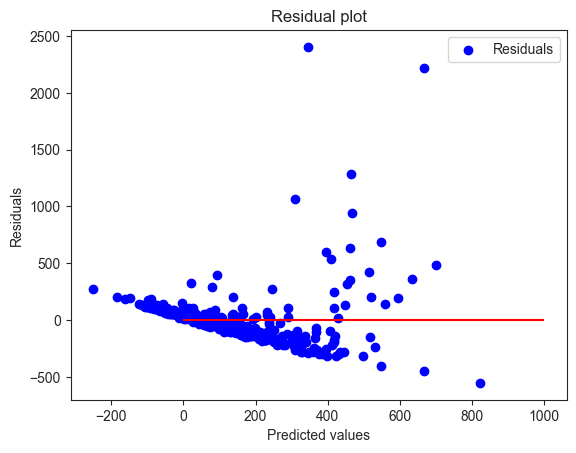

In [58]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
x_plot = plt.scatter(y_pred, residuals, c='b', label='Residuals')
plt.hlines(y=0, xmin= 0, xmax=1000, color='r', linestyles="-")
plt.title('Residual plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

Unsurprisingly, our plotted residuals show that the model suffers from heteroscedasticy and an imperfect linear relationship, which could be the cause of the high MSE and low R-squared.

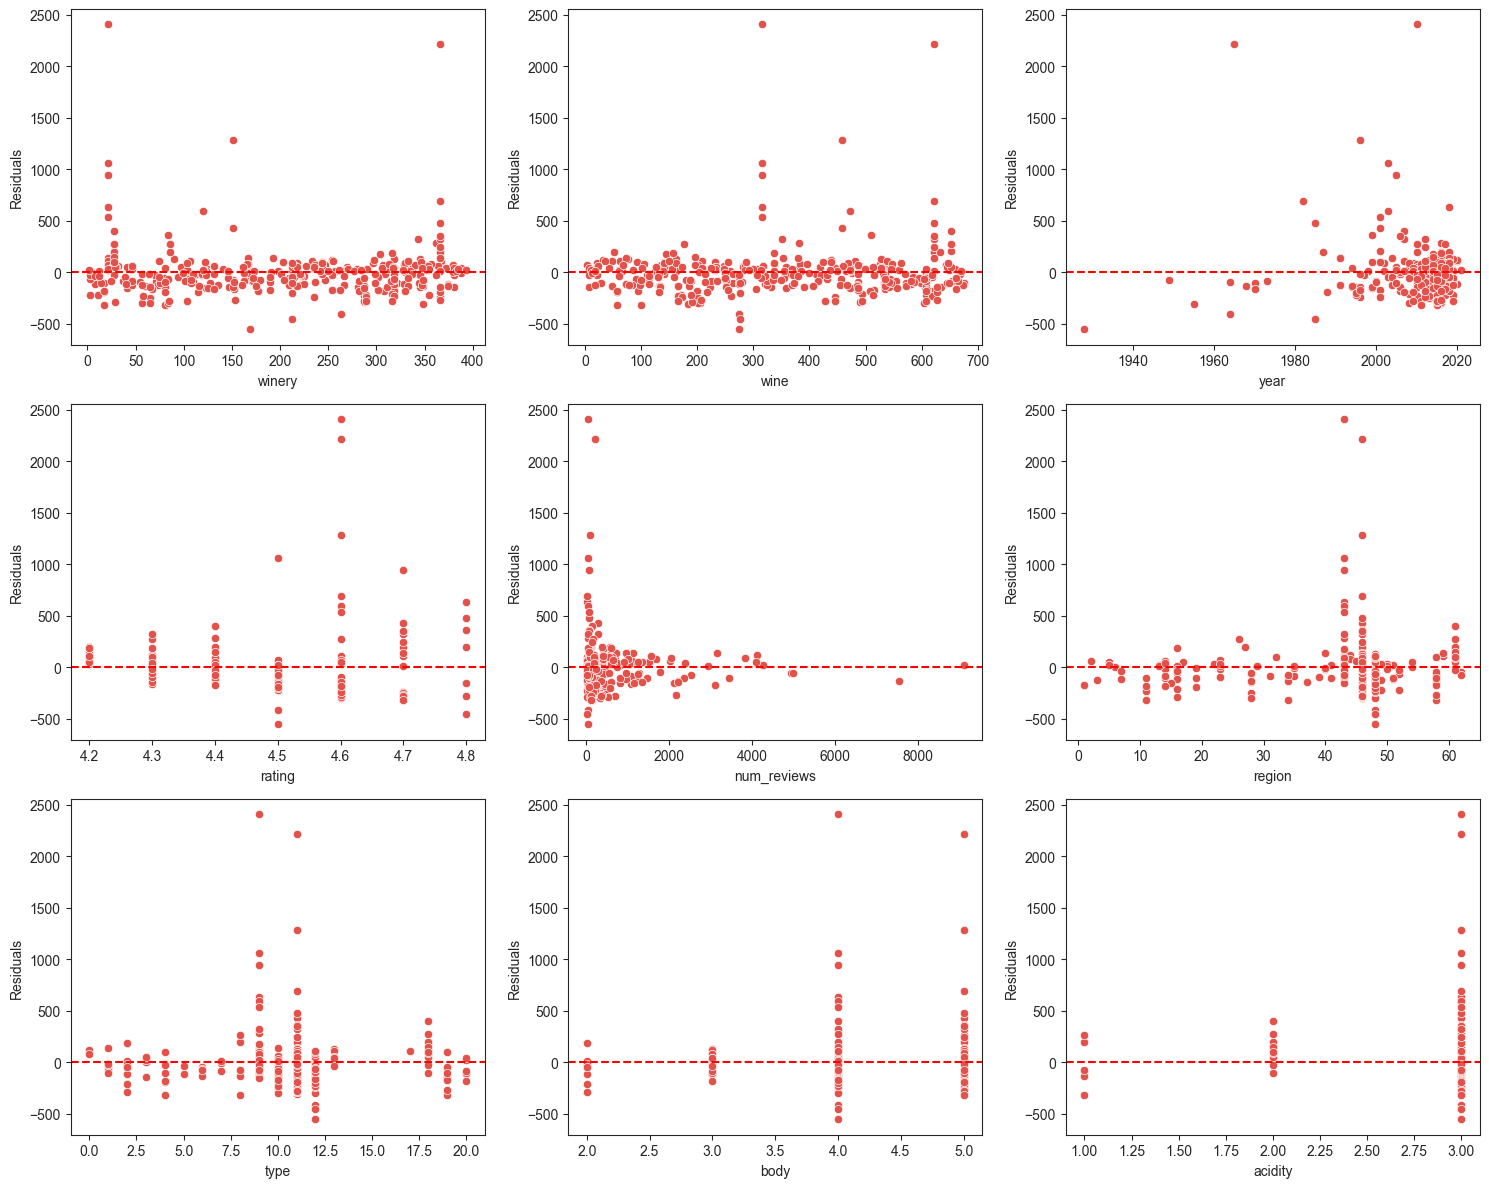

In [59]:
# Plot residuals against each predictor
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    if i < len(X.columns):
        sns.scatterplot(x=X_test.iloc[:, i], y=residuals, ax=ax)
        ax.set_xlabel(X.columns[i])
        ax.set_ylabel('Residuals')
        ax.axhline(y=0, color='r', linestyle='--')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

The residuals plotted against each predictor further confirm our results that the data may benefit from shrinkage methods or a transformation of the price, given the non-linear relationships exhibited in the majority of the plots. Moreover, many of the independent predictors show the heteroscedasticity from our general residuals plot.

In [60]:
# Create a new DataFrame with log-transformed price
df_linear = df.copy()
df_linear['log_price'] = np.log(df['price'])

X = df_linear.drop(['price', 'log_price'], axis=1)
y = df_linear['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE (on log-transformed prices): {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R^2 (on log-transformed prices): {r2}")

MSE (on log-transformed prices): 0.48812870834951416
R^2 (on log-transformed prices): 0.5710415471876165


After transforming price to log_price, our model has a much better fit to the data and a much lower MSE, indicating it was the right step. It now capturess ± 57% of the variance in the model, or a 28% increase over our initial model.

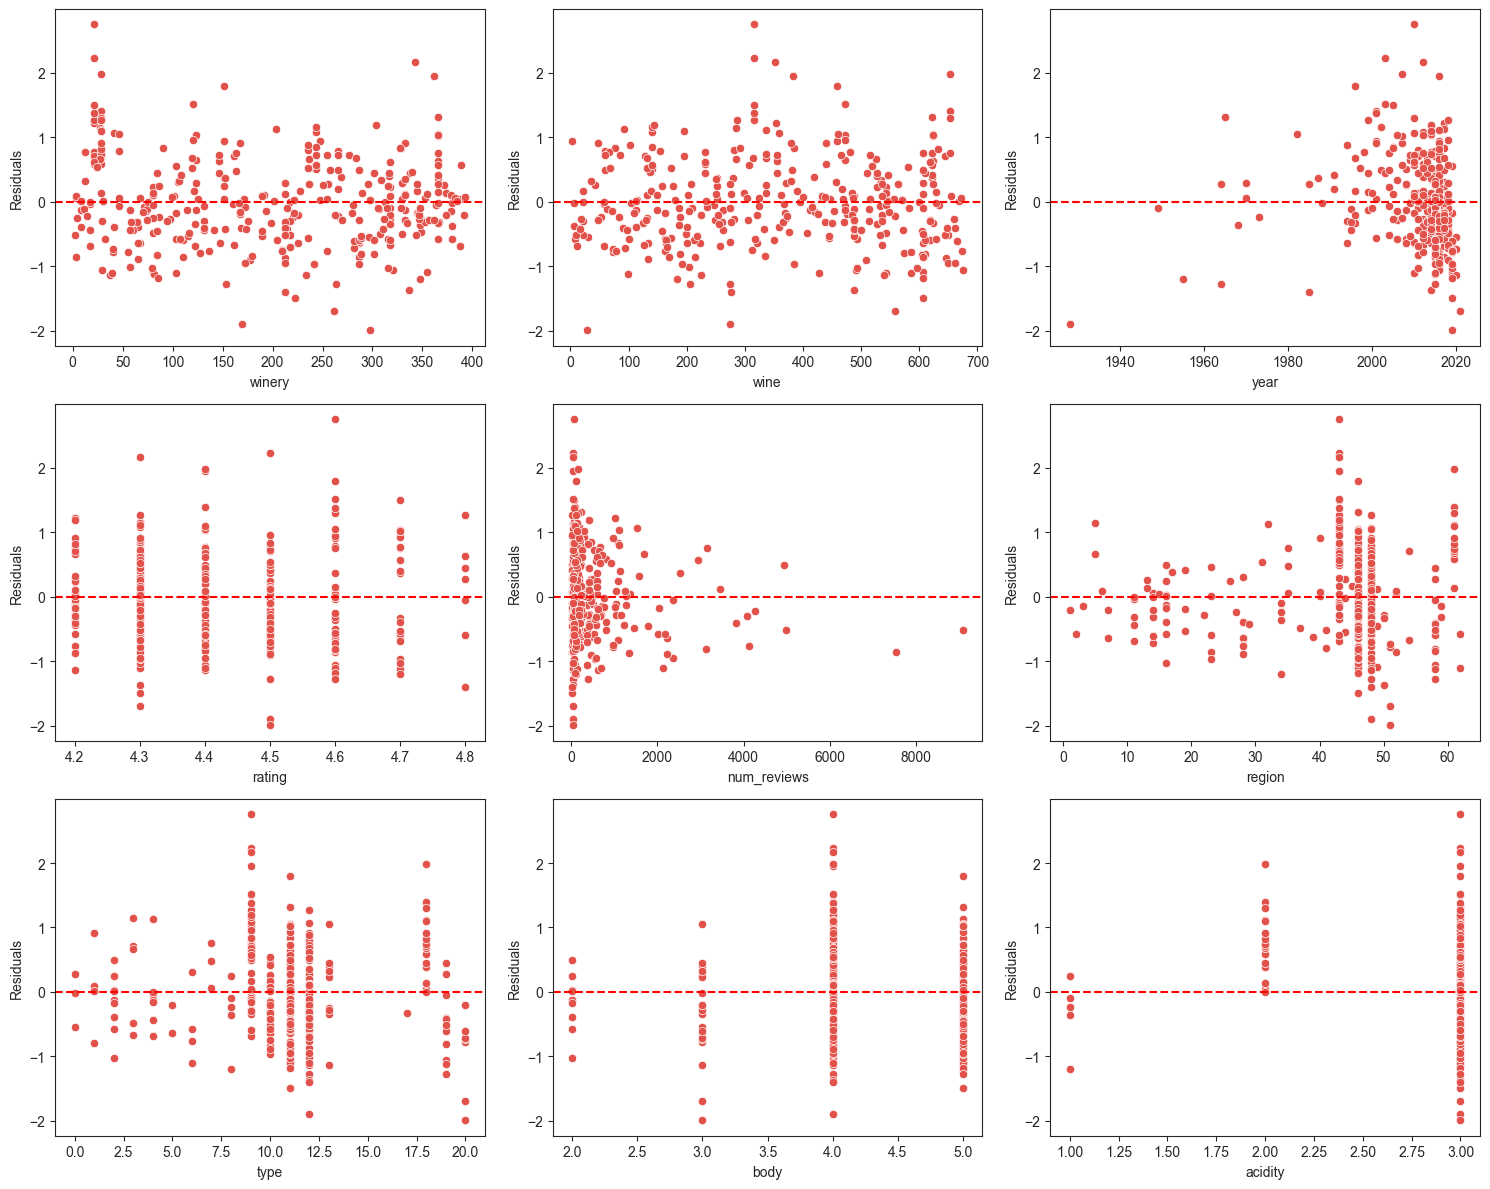

In [61]:
# Calculate the new residuals
residuals = y_test - y_pred

# Plot residuals against each predictor
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    if i < len(X.columns):
        sns.scatterplot(x=X_test.iloc[:, i], y=residuals, ax=ax)
        ax.set_xlabel(X.columns[i])
        ax.set_ylabel('Residuals')
        ax.axhline(y=0, color='r', linestyle='--')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

The predictor also benefitted from the transformation of price. Heteroscedasticity has largely decreased and lead to more even distributions among observations. However, it remains high in number of reviews.

In [62]:
# Calculate coefficients
coefficients = lr.coef_
intercept = lr.intercept_

# Calculate p-values
X_test_sm = sm.add_constant(X_test)
model = sm.OLS(y_test, X_test_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     53.98
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           7.59e-60
Time:                        20:33:02   Log-Likelihood:                -354.55
No. Observations:                 343   AIC:                             729.1
Df Residuals:                     333   BIC:                             767.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.1423      7.521      7.997      

In this model, rating remains the most influential predictor of wine prices, showcasing a 398% increase for every unit increase in rating due to the logarithmic transformation of price. The effect of vintage years also shows a pronounced impact, with each additional year correlating with a 3.69% decrease in price. Region is also signficant (p > 0.05), however, it's impact on price is only 1%.

# Making a prediction of the price of a wine with the following features: winery = 'Alvaro Palacios', wine = 'L'Ermita Velles Vinyes Priorat', year = 2023, rating = 4.5, num_reviews = 321, region = 'Priorato', type = 'Priorat Red', body = 4.5, acidity = 3.0.

In [63]:
# Check the encoded values
encoded_value = label_mapping['winery']['Alvaro Palacios']

print(f"Encoded value: {encoded_value}")

# Retrieve the original label
original_label = next(key for key, value in label_mapping['winery'].items() if value == encoded_value)

print(f"Original label for encoded value {encoded_value}: {original_label}")

Encoded value: 21
Original label for encoded value 21: Alvaro Palacios


In [64]:
lr = LinearRegression()
lr.fit(X_train,y_train)

residuals = y_test - y_pred
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

wine_9 = {
    'winery': 21,
    'wine': 315,
    'year': 2023,
    'rating': 4.5,
    'num_reviews': 321,
    'region': 43,
    'type': 9,
    'body': 4.5,
    'acidity': 3.0
}

price_predicted = lr.predict(pd.DataFrame(wine_9, index=[0]))

# Confidence intervals
lower_bound = price_predicted - 2 * std_residuals
upper_bound = price_predicted + 2 * std_residuals

print(f"Predicted price: {np.exp(price_predicted[0]):.2f}€")
print(f"95% Confidence Interval: [{np.exp(lower_bound[0]):.2f}, {np.exp(upper_bound[0]):.2f}]€")

Predicted price: 74.80€
95% Confidence Interval: [18.49, 302.51]€


Based on the analysis, we can predict that the price is approximately €74.80. To understand the certainty of this prediction, we provide a 95% confidence interval, which ranges from €18.49 to €302.51. 

This confidence interval means that we are 95% confident that the true price lies within this range. While the predicted price is €74.80, the wide interval indicates that there is substantial variability, and the true price could potentially be much lower or higher than the predicted value. Therefore, while we have a point estimate, the prediction comes with considerable uncertainty, reflected in the broad confidence interval.

# Using a random forest regressor model to predict the price of the wine with the previous features.

In [65]:
# Create the random forest regressor with OOB predictions enabled
rf_reg = RandomForestRegressor(oob_score=True)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}

# Search for best parameters
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R2 Score: {r2:.3f}")

price_predicted = best_model.predict(pd.DataFrame(wine_9, index=[0]))[0]
price_predicted_exp = np.exp(price_predicted)
print(f"Predicted Price with Random Forest: {price_predicted_exp:.2f}€")

# Calculate the standard deviation of the OOB predictions
oob_predictions = best_model.oob_prediction_
oob_residuals = y_train - oob_predictions
std_oob_residuals = np.std(oob_residuals)

# Confidence intervals
lower_bound = price_predicted - 2 * std_oob_residuals
upper_bound = price_predicted + 2 * std_oob_residuals

print(f"95% Confidence Interval: [{np.exp(lower_bound):.2f}€, {np.exp(upper_bound):.2f}€]")


Best parameters: {'max_depth': 20, 'n_estimators': 300}
Best score: 0.6981981032068603
R2 Score: 0.734
Predicted Price with Random Forest: 36.93€
95% Confidence Interval: [11.44€, 119.22€]


The Random Forest model predicts a lower price of 42.56€ with a 95% confidence interval of 13.01€ to 139.18€. Although this interval is still broad, it is notably narrower than that of the Linear Regression model, indicating a relatively higher certainty in the prediction. The comparison suggests that the Random Forest model, with its narrower confidence interval, may provide more reliable and precise price estimates compared to the Linear Regression model, which exhibits greater variability and less certainty in its predictions.

Additionally, it has a better fit to the data, explaining 74.1%, or 17% more, of the variance in price.

# Using a pipeline to predict the rating of a wine.

In [66]:
df = pd.read_csv("/Users/emiliosayun/Documents/Msc Management Business Analytics/3rd Term/Data Science/Final Project/data/spanish_wines_dataset.csv", sep=',', encoding='utf-8', header=0)
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       2048 non-null   object 
 1   wine         2048 non-null   object 
 2   year         2046 non-null   object 
 3   rating       2048 non-null   float64
 4   num_reviews  2048 non-null   int64  
 5   country      2048 non-null   object 
 6   region       2048 non-null   object 
 7   price        2048 non-null   float64
 8   type         1942 non-null   object 
 9   body         1777 non-null   float64
 10  acidity      1777 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 176.1+ KB


In [68]:
# Drop 'country'

df = df.drop(columns=['country'])

In [69]:
# Convert 'year' to numeric

df = df[df['year'] != 'N.V.']
df['year'] = pd.to_numeric(df['year'])

In [70]:
# Convert rating to categorical using LabelEncoder
encoder= LabelEncoder()
df['rating'] = encoder.fit_transform(df['rating'])

X = df.drop(columns=['rating'])
y = df['rating']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Numerical features
numeric_features = ['year', 'num_reviews', 'price', 'body', 'acidity']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical features
categorical_features = ['winery', 'wine', 'region', 'type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Once the numerical and categorical features have been separately processed using their respective pipelines—numerical features undergoing imputation and scaling, and categorical features undergoing imputation and one-hot encoding—the ColumnTransformer merges these transformed datasets back together. This ensures that all transformations are applied consistently across both types of features, maintaining data integrity and preparing it for the model.

By consolidating these processed features into a single dataset, the ColumnTransformer effectively constructs a structured input that aligns with the expectations of the machine learning model. This step is crucial because it allows the model to interpret and utilize the entire dataset comprehensively.

In [71]:
# Define the pipeline with preprocessing and classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

The classifier step then learns from the preprocessed data to predict binary outcomes based on the input features. This structured approach not only simplifies the workflow by encapsulating preprocessing and modeling steps but also optimizes the logistic regression model's ability to generalize and make accurate predictions based on the transformed data.

In [72]:
# Define the parameter grid
param_grid = [
    {
        'classifier': [LogisticRegression()],
        'preprocessor__num__imputer__strategy': ['mean', 'median'],
        'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent'],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'classifier': [RandomForestClassifier()],
        'preprocessor__num__imputer__strategy': ['mean', 'median'],
        'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent'],
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 10, 20]
    }
]

This parameter grid specifies different settings for improving the model's performance through grid search with cross-validation. It considers two types of models: logistic regression and random forest. For logistic regression, it tests various strengths of regularization (which helps prevent the model from becoming too complex), as well as different ways to handle missing data in both numerical and categorical features. For random forest, it explores different numbers of trees in the forest and how deep each tree should grow. By trying out these combinations, the goal is to find the best setup that improves how accurately the model can predict outcomes using new data.

In [73]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")

/opt/miniconda3/envs/ds/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/ds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

Best Parameters: {'classifier': RandomForestClassifier(), 'classifier__max_depth': None, 'classifier__n_estimators': 100, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'mean'}


Grid search is performed and fitted to the training data. The best parameters and estimator are searched.

In [74]:
# Make predictions with the best model
predictions = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4781144781144781


Finally, the prediction is made with the best parameters found.
An accuracy score of 0.478 means that the model correctly predicted the outcome approximately 47.8% of the time on the dataset it was evaluated on. In other words, out of all predictions made by the model, about 47.8% were correct.

# Fine-tuning and comparing a Suppor Vector Model, a Gradient Boosting or Random Forest Model, and a Naïve Bayes Model.

In [75]:
# Convert rating to categorical using LabelEncoder
le = LabelEncoder()
df['rating'] = le.fit_transform(df['rating'])

X = df.drop(columns=['rating'])
y = df['rating']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [76]:
# Define pipelines for each model
pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC())
])

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('model', GaussianNB())
])

In [77]:
# Define the parameter grid for each model
param_grid_svc = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent']
}

param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__random_state': [42],  # Added random_state as an example parameter
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent']
}

param_grid_nb = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__cat__imputer__strategy': ['constant', 'most_frequent']
}

In [78]:
# Perform grid search with cross-validation for each model
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5)
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5)
grid_search_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=5)

# Fit the grid search for each model
grid_search_svc.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_nb.fit(X_train, y_train)

# Get the best parameters and estimator for each model
best_params_svc = grid_search_svc.best_params_
best_estimator_svc = grid_search_svc.best_estimator_
print(f"Best Parameters - SVM: {best_params_svc}")

best_params_rf = grid_search_rf.best_params_
best_estimator_rf = grid_search_rf.best_estimator_
print(f"Best Parameters - Random Forest: {best_params_rf}")

best_params_nb = grid_search_nb.best_params_
best_estimator_nb = grid_search_nb.best_estimator_
print(f"Best Parameters - Naive Bayes: {best_params_nb}")

/opt/miniconda3/envs/ds/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/envs/ds/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters - SVM: {'model__C': 10, 'model__kernel': 'rbf', 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'mean'}
Best Parameters - Random Forest: {'model__n_estimators': 50, 'model__random_state': 42, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'mean'}
Best Parameters - Naive Bayes: {'preprocessor__cat__imputer__strategy': 'constant', 'preprocessor__num__imputer__strategy': 'mean'}


In [79]:
# Make predictions with the best models
predictions_svc = best_estimator_svc.predict(X_test)
predictions_rf = best_estimator_rf.predict(X_test)
predictions_nb = best_estimator_nb.predict(X_test)

# Evaluate the models
accuracy_svc = accuracy_score(y_test, predictions_svc)
accuracy_rf = accuracy_score(y_test, predictions_rf)
accuracy_nb = accuracy_score(y_test, predictions_nb)

# Evaluate the models
mse_svc = mean_squared_error(y_test, predictions_svc)
mse_rf = mean_squared_error(y_test, predictions_rf)
mse_nb = mean_squared_error(y_test, predictions_nb)

print(f"SVC MSE: {mse_svc}")
print(f"Random Forest MSE: {mse_rf}")
print(f"Naive Bayes MSE: {mse_nb}")

print(f"Accuracy - SVM: {accuracy_svc}")
print(f"Accuracy - Random Forest: {accuracy_rf}")
print(f"Accuracy - Naive Bayes: {accuracy_nb}")

SVC MSE: 1.245791245791246
Random Forest MSE: 1.3888888888888888
Naive Bayes MSE: 3.8063973063973062
Accuracy - SVM: 0.43602693602693604
Accuracy - Random Forest: 0.47474747474747475
Accuracy - Naive Bayes: 0.2558922558922559


| Model             | MSE       | Accuracy |
|-------------------|-----------|----------|
| SVM               |   1.25    |   0.43   |
| Random Forest     |   1.39    |   0.47   |
| Naive Bayes       |   3.81    |   0.25   |

The Support Vector Machine (SVM) model achieved a Mean Squared Error (MSE) of approximately 1.25 and an accuracy of about 43.6%. The MSE measures the average squared difference between the predicted and actual wine ratings, with a lower MSE indicating better predictive accuracy. Despite the relatively lower MSE, the accuracy of 43.6% suggests that the SVM model correctly predicts wine ratings less than half of the time. This implies there is room for improvement in capturing the nuances of wine characteristics that determine ratings.

The Random Forest model resulted in an MSE of approximately 1.39 and demonstrated a higher accuracy of about 47.5%. The slightly higher MSE compared to SVM indicates that, on average, its predictions deviate more from the actual values. However, the higher accuracy of 47.5% suggests that the Random Forest model performs relatively better in correctly predicting wine ratings compared to SVM. This ensemble model's ability to handle complex relationships in data likely contributes to its improved accuracy.

The Naive Bayes model had the highest MSE of approximately 3.81 and the lowest accuracy of about 25.6%. This indicates that, on average, its predictions deviate significantly from the actual ratings, highlighting its limitations in capturing the nuanced patterns in wine rating data. The low accuracy of 25.6% further reinforces its struggles in making correct predictions, aligning with actual ratings only about a quarter of the time. Naive Bayes' assumption of feature independence might not hold well in this context, negatively impacting its predictive performance.

# What are the most important features that determine the rating?

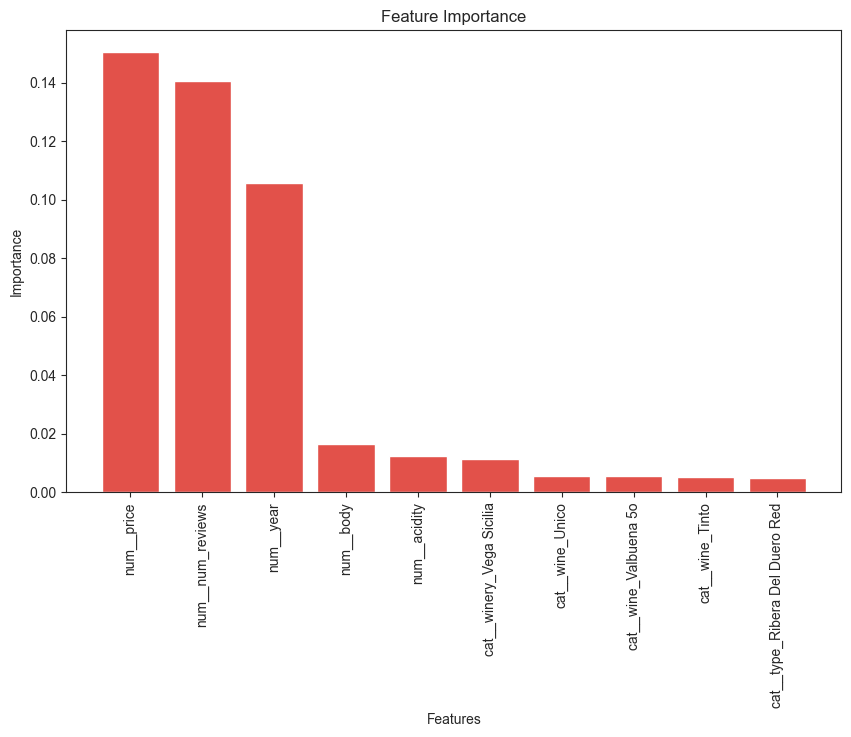

In [80]:
# Fit the preprocessor
preprocessor.fit(X_train)

# Fit the Random Forest model to determine feature importance
best_rf = grid_search_rf.best_estimator_

# Extract feature importances
feature_importances = best_rf.named_steps['model'].feature_importances_

# Get the indices of the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Get the feature names after the preprocessor has been fitted
feature_names = preprocessor.get_feature_names_out()

# Select the top 10 features
top_indices = indices[:10]
top_feature_importances = feature_importances[top_indices]
top_feature_names = np.array(feature_names)[top_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_importances)), top_feature_importances, align='center')
plt.xticks(range(len(top_feature_importances)), top_feature_names, rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


The graphs shows that the most important features that determine the rating of wines are price, number of reviews, and year of harvest. Other features such as the wine's body and acidity also contribute to the predictions, though their importance is moderate compared to price and number of reviews. These features still influence the ratings but are not as pivotal.harvest.

Interestingly, specific categorical features such as particular wineries and wines (like Vega Sicilia and Unico) and the wine's region (Ribera del Duero) have relatively low importance. This indicates that while the brand and type of wine do matter, they are not the primary predictors in this model.

# Designing and training a simple neural network to predict the rating of a wine.

In [83]:
# Load the data
df = pd.read_csv("/Users/emiliosayun/Documents/Msc Management Business Analytics/3rd Term/Data Science/Final Project/data/spanish_wines_dataset.csv", sep=',', encoding='utf-8', header=0)

# Drop rows with missing values
df.dropna(inplace=True)

# Drop 'country'
df = df.drop(columns=['country'])

# Convert 'year' to numeric
df = df[df['year'] != 'N.V.']
df['year'] = pd.to_numeric(df['year'])

# Convert rating to categorical using LabelEncoder
le = LabelEncoder()
df['rating'] = le.fit_transform(df['rating'])

# One-Hot Encode categorical features
categorical_cols = ['winery', 'region', 'type', 'wine']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [84]:
# Separate features and target
X = df_encoded.drop(columns=['rating'])
y = df_encoded['rating']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the neural network model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
y_pred_nn = model.predict(X_test)

# Compute Mean Squared Error
mse_nn = np.mean((y_test - y_pred_nn.flatten())**2)
print(f'Mean Squared Error of Neural Network: {mse_nn}')

# Calculate accuracy
threshold = 0.5
y_pred_class_nn = (y_pred_nn.flatten() >= threshold).astype(int)
y_test_class = (y_test >= threshold).astype(int)
accuracy_nn = np.mean(y_pred_class_nn == y_test_class)
print(f'Accuracy of Neural Network: {accuracy_nn:.4f}')

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3819 - val_loss: 2.6848
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0091 - val_loss: 2.4051
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1847 - val_loss: 2.3662
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1499 - val_loss: 2.0939
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7085 - val_loss: 1.8899
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5998 - val_loss: 1.9416
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2613 - val_loss: 2.0869
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3801 - val_loss: 1.9037
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2297 - val_loss: 1.9670
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1640 - val_loss: 1.8122
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0763 - val_loss: 1.8425
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1

The NN achieved a Mean Squared Error of 1.6267, indicating its ability to minimize prediction error on the continuous rating scale. This MSE is higher than that of SVC (1.2458) and Random Forest (1.3889), but notably lower than Naive Bayes (3.8064), suggesting that the NN generally outperforms Naive Bayes in terms of prediction accuracy for continuous ratings.

Moreover, the NN achieved an accuracy of 0.8805, which significantly surpasses the accuracies of SVC (0.4360), Random Forest (0.4747), and Naive Bayes (0.2559). This higher accuracy indicates that the NN more accurately classified the categorical rating classes derived from the predictions.

Despite the NN's higher MSE relative to SVC and Random Forest, its superior accuracy suggests it excels in correctly classifying categorical rating classes derived from its predictions. While the NN may not minimize squared errors as effectively as other models, its more adept at categorizing ratings.

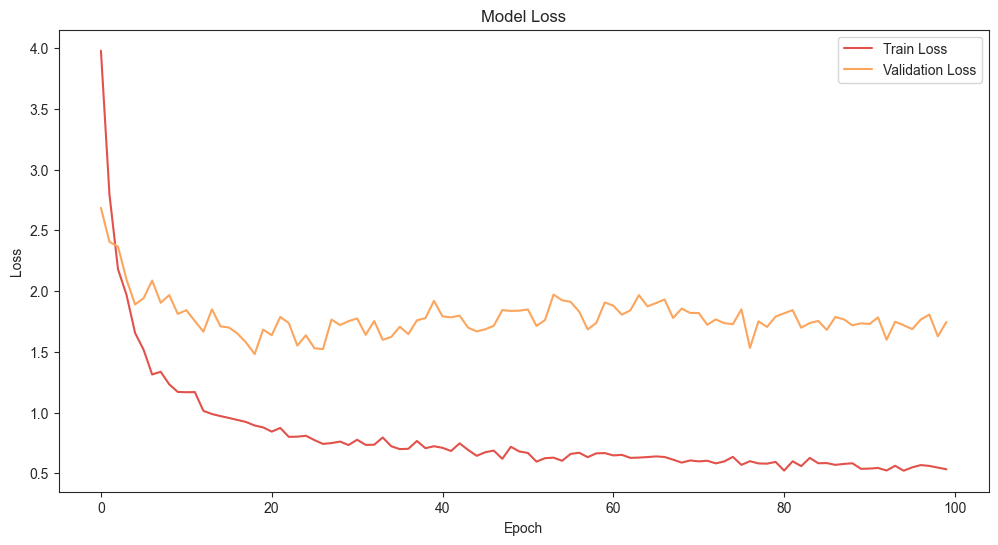

In [85]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

The training loss starts high, decreases rapidly in the initial epochs, and continues to decrease gradually, stabilizing at a low value towards the end of the training process. This indicates that the model is learning and fitting the training data well over time.

The validation loss also starts high and decreases initially, showing that the model is generalizing well to the validation data. However, after around 20 epochs, it starts to fluctuate and stabilize without further significant decreases.

The separation between the training loss and validation loss after approximately 20 epochs indicates the beginning of overfitting. While the training loss keeps decreasing, showing that the model is getting better at predicting the training data, the validation loss doesn't decline at the same rate. This suggests that the model's capability to generalize to new, unseen data is not improving as effectively.